In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 3
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 5000
n_test = 1000
tries = 3

x_train, y_train, x_test, y_test, rotation = pickle.load(open('data.pickle', 'rb'))

x_train = x_train[:n]
y_train = y_train[:n]
x_test = x_test[:n_test]
y_test = y_test[:n_test]

model, [H, H_], eval_data = pickle.load(open('result.pickle', 'rb'))

sample_range = [100, 200, 400, 800, 1600]

M = 100                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

In [15]:
np.min(y_test)

Array(0.01787533, dtype=float32)

In [16]:
np.max(y_test)

Array(6.7369766, dtype=float32)

In [2]:
W_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)
from numpy import linalg
true_H = jnp.matmul(jnp.transpose(W_grad), W_grad) / n_test

eigenvalues, eigenvectors = linalg.eig(true_H)

In [3]:
y_hat_test, history, X_bd_all, w_trees = model
mean_squared_error(y_test, y_hat_test)

0.112688676

In [4]:
true_grad = vmap(grad(simulate_y, argnums=0), in_axes=(0, None), out_axes=0)(x_test, rotation)[:, 0]

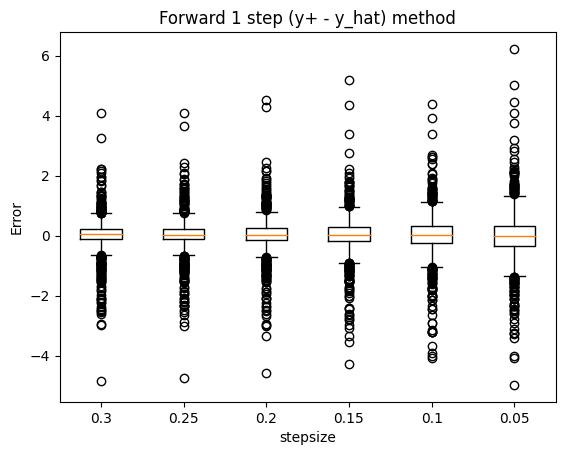

In [12]:
steps = []
grad_errors = []
for [step_size, x_temp, y_hat_eval] in eval_data[:-10]:
    if step_size > 0:
        estimated_grads = (y_hat_eval - y_hat_test)/step_size - true_grad  # Generating random data for demonstration
        steps.append(step_size)
        grad_errors.append(estimated_grads)

plt.boxplot(grad_errors, labels=steps)
plt.title('Forward 1 step (y+ - y_hat) method')
plt.xlabel('stepsize')
plt.ylabel('Error')
plt.show()

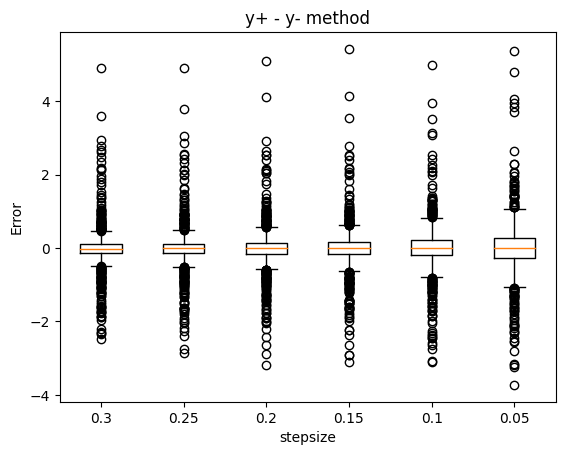

In [13]:
steps = []
grad_errors = []
for i in range(len(eval_data[:-10])):
    step_size, x_temp, y_hat_eval = eval_data[i]
    if step_size > 0:
        _, _, y_hat_eval_down = eval_data[i + 1]
        estimated_grads = (y_hat_eval - y_hat_eval_down)/(step_size * 2) - true_grad  # Generating random data for demonstration
        steps.append(step_size)
        grad_errors.append(estimated_grads)

plt.boxplot(grad_errors, labels=steps)
plt.title('y+ - y- method')
plt.xlabel('stepsize')
plt.ylabel('Error')
plt.show()

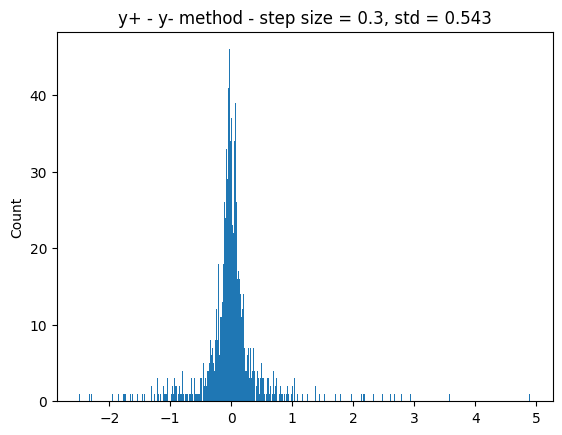

In [7]:
step_size, x_temp, y_hat_eval = eval_data[0]
_, _, y_hat_eval_down = eval_data[1]
estimated_grads = (y_hat_eval - y_hat_eval_down)/(step_size * 2) - true_grad  # Generating random data for demonstration
plt.hist(estimated_grads, bins = 500)
plt.title(f'y+ - y- method - step size = {step_size}, std = {np.std(estimated_grads):.3f}')
plt.ylabel('Error')
plt.ylabel('Count')
plt.show()

In [8]:
print(np.mean(abs(estimated_grads)))
np.std(estimated_grads)

0.28993264


Array(0.54263073, dtype=float32)

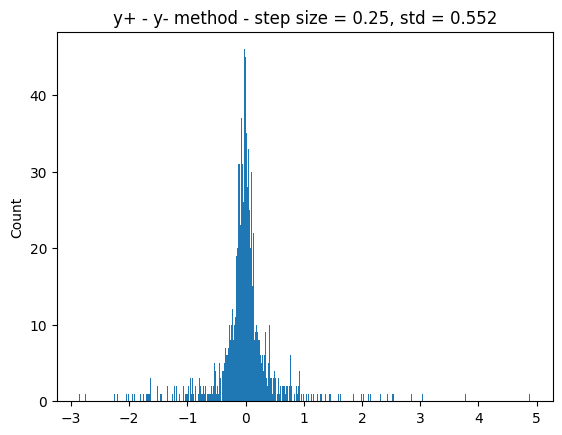

In [9]:
step_size, x_temp, y_hat_eval = eval_data[2]
_, _, y_hat_eval_down = eval_data[3]
estimated_grads = (y_hat_eval - y_hat_eval_down)/(step_size * 2) - true_grad  # Generating random data for demonstration
plt.hist(estimated_grads, bins = 500)
plt.title(f'y+ - y- method - step size = {step_size}, std = {np.std(estimated_grads):.3f}')
plt.ylabel('Error')
plt.ylabel('Count')
plt.show()

0.04229429
0.9282523


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  2.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  3.,  0.,  0.,  1.,  1.,  2.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.

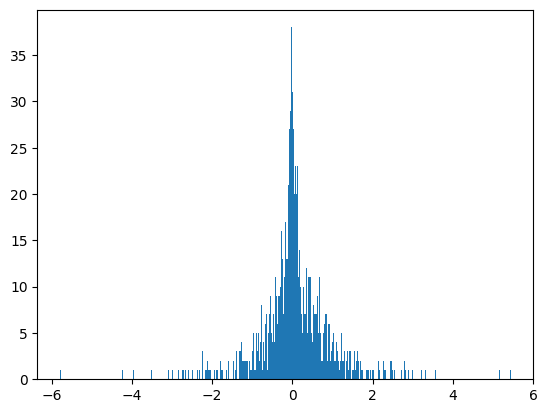

In [10]:
print(np.mean(true_grad))
print(np.std(true_grad))
plt.hist(true_grad, bins = 500)